<a href="https://colab.research.google.com/github/szostaklab/AI_PPP_Ribozyme/blob/main/pppLandscape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# libraries
!pip install decorator==5.0.9
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
!pip install Levenshtein
from Levenshtein import distance as levenshtein_distance
from sklearn.cluster import KMeans
import collections

In [2]:
#Define functions and constants

rs1 = 'GAATGCTGCCAACCGTGCGGGCTAATTGGCAGACTGAGCT'
quality_cutoff = 0.9 

def seqmatch(seq1, seq2):
  overall = 0
  overlap = 0
  for pos in range(len(seq1)):
    overall+=1
    if seq1[pos] == seq2[pos]:
      overlap+=1
  return overlap/overall

#https://www.geeksforgeeks.org/building-an-undirected-graph-and-finding-shortest-path-using-dictionaries-in-python/
# Python implementation to find the
# shortest path in the graph using
# dictionaries

# Function to find the shortest
# path between two nodes of a graph
def BFS_SP(graph, start, goal):
	explored = []
	
	# Queue for traversing the
	# graph in the BFS
	queue = [[start]]
	
	# If the desired node is
	# reached
	if start == goal:
		print("Same Node")
		return
	
	# Loop to traverse the graph
	# with the help of the queue
	while queue:
		path = queue.pop(0)
		node = path[-1]
		
		# Condition to check if the
		# current node is not visited
		if node not in explored:
			neighbours = graph[node]
			
			# Loop to iterate over the
			# neighbours of the node
			for neighbour in neighbours:
				new_path = list(path)
				new_path.append(neighbour)
				queue.append(new_path)
				
				# Condition to check if the
				# neighbour node is the goal
				if neighbour == goal:
					return new_path
			explored.append(node)

	# Condition when the nodes
	# are not connected
	return 0

In [3]:
#Upload raw seqs
raw_seqs = []
for round in range(1,7):
    raw_seqs.append(open('/Users/zoeweiss/Desktop/Desktop/lab(s)/szostak/spring 2022/ppp landscape/seqs/ppp-'+str(round)+'_S'+str(round)+'_L001_R2_001.fastq').readlines())

#Filter by quality
all_high_quality = []
unique_high_quality = []
for round in raw_seqs:
    high_quality = []
    seqs = round[1::4]
    qualities = round[3::4]
    acceptable_quals_1_percent_error = [5,6,7,8,9,':',';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
    for seq in range(len(qualities)):
        overlap=0
        for char in list(set(qualities[seq]).intersection(acceptable_quals_1_percent_error)):
            overlap+=qualities[seq].count(char)
        if overlap/len(qualities[1])>quality_cutoff:
            high_quality.append(seqs[seq].strip("\n"))
    print('High quality seqs r'+str(1+raw_seqs.index(round))+': '+str(len(high_quality)))
    all_high_quality.append(high_quality)
    unique_high_quality.append(list(set(high_quality)))
    print('Unique high quality seqs r'+str(1+raw_seqs.index(round))+': '+str(len(list(set(high_quality)))))
    

High quality seqs r1: 1793335
Unique high quality seqs r1: 1658322
High quality seqs r2: 1824368
Unique high quality seqs r2: 1617437
High quality seqs r3: 1238531
Unique high quality seqs r3: 301725
High quality seqs r4: 1959238
Unique high quality seqs r4: 136149
High quality seqs r5: 1553726
Unique high quality seqs r5: 115878
High quality seqs r6: 1515844
Unique high quality seqs r6: 126708


In [4]:
#Trim seqs to randomized region
all_trimmed_seqs = []
all_unique_trimmed_seqs = []
round = 1
for round in range(len(all_high_quality)):
    trimmed_seqs = []
    for seq in all_high_quality[round]:
        if 'ACTCACTGACACAGATCCACTCACGGACAGCG' in seq and 'CGCTGTCC' in seq:
            if len(seq[len('ACTCACTGACACAGATCCACTCACGGACAGCG')+seq.index('ACTCACTGACACAGATCCACTCACGGACAGCG'):seq.index('CGCTGTCC')]) == 40:
                trimmed_seqs.append(seq[len('ACTCACTGACACAGATCCACTCACGGACAGCG')+seq.index('ACTCACTGACACAGATCCACTCACGGACAGCG'):seq.index('CGCTGTCC')])
    all_trimmed_seqs.append(trimmed_seqs)
    all_unique_trimmed_seqs.append(list(set(trimmed_seqs)))


In [5]:
#Cluster top sequences
k = 15
matrix = np.asarray([np.fromstring(str(s), dtype=np.uint8) for s in all_unique_trimmed_seqs[-1]]);
kmeans = KMeans(init="random", n_clusters=k,n_init=10,max_iter=300,random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_[:]

all_clusters = []
for cluster_num in range(0, k):
  seqs_in_cluster = []
  for seq in range(len(labels)):
    if labels[seq] == cluster_num:
      seqs_in_cluster.append(all_unique_trimmed_seqs[-1][seq])
  all_clusters.append(seqs_in_cluster)

order_of_clusters = []
for rank in labels:
    if rank not in order_of_clusters:
        order_of_clusters.append(rank)
all_clusters_ordered = []
for cluster_num in order_of_clusters:
    all_clusters_ordered.append(all_clusters[cluster_num])


<ipython-input-5-d12181a94a5d>:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  matrix = np.asarray([np.fromstring(str(s), dtype=np.uint8) for s in all_unique_trimmed_seqs[-1]]);


In [6]:
#Find peak seqs
peak_seqs = []
peak_clusters = []
top_seqs = collections.Counter(all_trimmed_seqs[-1]).most_common(10000)

i = 0
while len(peak_clusters)<11:
    top_seq = top_seqs[i]
    for cluster in all_clusters_ordered:
        if top_seq[0] in cluster:
            if all_clusters_ordered.index(cluster) not in peak_clusters:
                peak_clusters.append(all_clusters_ordered.index(cluster))
                peak_seqs.append(top_seq[0])
                print(top_seq)
    i+=1

('GACAGCCGAGAAATGAGTGGCCTAAATGGGAGAATGAGCT', 143854)
('GACTGCGCGTATGAGTGGCGGCTAAAGAGGAGAATGAGCG', 125090)
('ACGGGTGGGTAATCTAGTGTCCGCGGAATAGAACGAAACA', 94478)
('GACAGCGGAGAACTGAGTGGCCTAATTGGGAGAATGAGCT', 29821)
('GGAGGGTGACATCGTTGAGAGAGAATGGGGATATTGAACT', 713)
('AAGCTCTCGCCAGCAAAAGAACAGACCGTCGAGGAAACGG', 339)
('CAATGCTATCCTCGGGGAACGATTCTGCGGAATCCGACAT', 306)
('GAATCTGGCGAACGATTAGTCCTAATTGAGAATTATAGTT', 262)
('ACAAGCGACGAATGGTGCGGGTTAATTGGTGGGGTGATCT', 252)
('GTGTGTTACGAACCGTGGCGACTAAGCGGGAGGGTGAACT', 121)
('GCAGGGTGACACTGGTGCGAGAGAATGGGAAGACAATGCT', 95)


In [7]:
#Plot dynamics
#Count each peak in each round
all_peak_counts = []
for peak in peak_seqs:
    counts = []
    for round in range(len(all_trimmed_seqs)):
        counts.append(all_trimmed_seqs[round].count(peak))
    all_peak_counts.append(counts)

#Count RS1 in each round
all_rs1_counts = []
for round in range(len(all_trimmed_seqs)):
    all_rs1_counts.append(all_trimmed_seqs[round].count(rs1))

#Find total counts
all_total_counts = []
for round in range(len(all_trimmed_seqs)):
  all_total_counts.append(len(all_trimmed_seqs[round]))

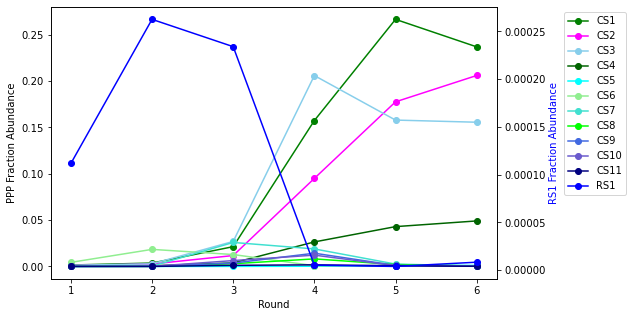

In [8]:
#Plot the dynamics
palate = ['green', 'magenta', 'skyblue', 'darkgreen', 'cyan', 'lightgreen', 'turquoise', 'lime', 'royalblue', 'slateblue', 'navy']

fig, ax1 = plt.subplots(figsize = (8,5))

lns = []
ax2 = ax1.twinx()

counter = 0
for seq in all_peak_counts:
    lns+= ax1.plot(range(1,7), np.array(seq)/np.array(all_total_counts), marker = 'o', color = palate[counter], label = 'CS'+str(1+all_peak_counts.index(seq)))
    counter+=1
lns+= ax2.plot(range(1,7), np.array(all_rs1_counts)/np.array(all_total_counts), marker = 'o', color = 'blue', label = 'RS1')

ax1.set_xlabel('Round')
ax1.set_ylabel('PPP Fraction Abundance')
ax2.set_ylabel('RS1 Fraction Abundance')
ax2.yaxis.label.set_color('blue')

# added these three lines
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, bbox_to_anchor = (1.3,1))

plt.show()

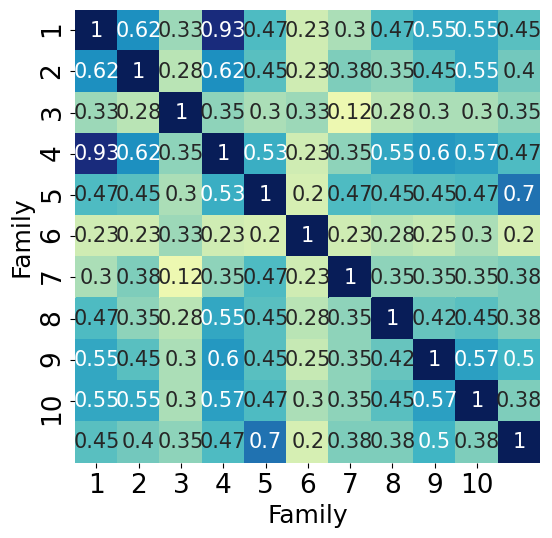

In [9]:
#How similar are the peak sequences
all_overlap = []
for seq1 in peak_seqs:
  overlap = []
  for seq2 in peak_seqs:
    overlap.append(seqmatch(seq1, seq2))
  all_overlap.append(overlap)

yticklabels = list(range(1, 11))
xticklabels = list(range(1, 11))

fig = plt.figure(num=1, figsize=(6, 6), dpi=100, facecolor='w', edgecolor='k')


ax = sns.heatmap(all_overlap, cbar=False, annot=True, annot_kws={"fontsize":15}, cmap="YlGnBu", yticklabels=yticklabels ,xticklabels=xticklabels,  vmin=0, vmax=1)
ax.set_ylabel('Family', fontsize=18)
ax.set_xlabel('Family', fontsize=18)
    
ax.tick_params(axis='both', which='major', labelsize=19)
ax.tick_params(axis='both', which='minor', labelsize=19)



40485
40485
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18

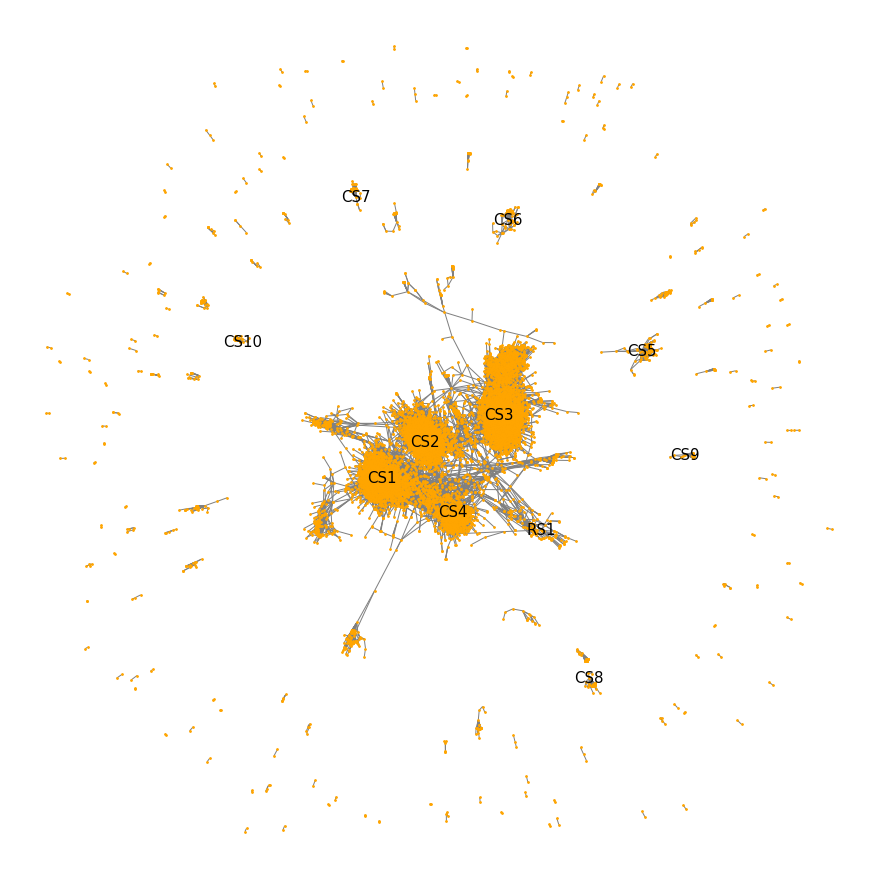

In [10]:
#Connections between sequences - which sequences are "close" to RS1 or CS1-5
connected_counts = []
for seq in all_trimmed_seqs[-1]:
  if seqmatch(seq.strip(), rs1)>.68:
    connected_counts.append(seq)
  else:
    for peak in peak_seqs:
      if seqmatch(seq.strip(), peak.strip())>.68:
        connected_counts.append(seq)
connected_counts = list(set(connected_counts))
print(len(connected_counts))

#Connection Matrix
connections = [ [ 0 for i in range(len(connected_counts)) ] for j in range(len(connected_counts)) ]
print(len(connected_counts))
for seq2 in range(len(connected_counts)):
  if seq2%100 == 0:
    print(seq2)
  for seq1 in range(len(connected_counts)):
    if int(seqmatch(connected_counts[seq1], connected_counts[seq2])*len(connected_counts[seq1])) == (len(connected_counts[seq1])-1):
      connections[seq1][seq2] = 1
connections_orig = connections

#Remove points with <10 connections
print('Counting columns')
cols_remove = [i for i, e in enumerate(np.sum(np.array(connections), axis = 1)) if e < 1]
print('Counting rows')
rows_remove = [i for i, e in enumerate(np.sum(np.array(connections), axis = 0)) if e < 1]

print('Deleting columns')
connections = np.delete(connections, list(set(cols_remove+rows_remove)), axis=1)
print('Deleting rows')
connections = np.delete(connections, list(set(cols_remove+rows_remove)), axis=0)

labeldict = {}

to_remove = 0
for element in list(set(cols_remove+rows_remove)):
    if element<connected_counts.index(rs1):
        to_remove+=1
labeldict[connected_counts.index(rs1)-to_remove] = 'RS1'


counter = 0
for peak in peak_seqs[:-1]:
    counter+=1
    to_remove = 0
    for element in list(set(cols_remove+rows_remove)):
        if element<connected_counts.index(peak):
            to_remove+=1
    labeldict[connected_counts.index(peak)-to_remove] = 'CS'+str(counter)


G = nx.from_numpy_matrix(np.array(connections))
plt.figure(figsize=(12,12)) 
#labeldict = {connections.index(connections[(connected_counts.index(rs1))]):'RS1'}
#for peak in range(len(peak_seqs)):
#    labeldict[connections.index(connections[(connected_counts.index(peak_seqs[peak]))])] = 'CS'+str(1+peak)
nx.draw(G, with_labels=True, labels = labeldict, font_color = 'black', node_color='orange', node_size=3, edge_color='grey', linewidths=1, font_size=15)
#nx.draw(G, font_color = 'black', node_color='orange', node_size=3, edge_color='grey', linewidths=1, font_size=15)


In [11]:
# Python implementation to find the
# shortest path in the graph using
# dictionaries
 
# Function to find the shortest
# path between two nodes of a graph
def BFS_SP(graph, start, goal):
    explored = []
     
    # Queue for traversing the
    # graph in the BFS
    queue = [[start]]
     
    # If the desired node is
    # reached
    if start == goal:
        print("Same Node")
        return
     
    # Loop to traverse the graph
    # with the help of the queue
    while queue:
        path = queue.pop(0)
        node = path[-1]
         
        # Condition to check if the
        # current node is not visited
        if node not in explored:
            neighbours = graph[node]
             
            # Loop to iterate over the
            # neighbours of the node
            for neighbour in neighbours:
                new_path = list(path)
                new_path.append(neighbour)
                queue.append(new_path)
                 
                # Condition to check if the
                # neighbour node is the goal
                if neighbour == goal:
                    return new_path
            explored.append(node)
 
    # Condition when the nodes
    # are not connected
    return 0
 

In [12]:
graph = {}
for element in range(len(connections_orig)):
    if element%1000==0:
        print(str(element)+'/'+str(len(connections_orig)))
    cons = []
    for col in range(len(connections_orig[element])):
        if connections_orig[element][col]!=0:
            cons.append(col)
    graph[element] = cons

0/40485
1000/40485
2000/40485
3000/40485
4000/40485
5000/40485
6000/40485
7000/40485
8000/40485
9000/40485
10000/40485
11000/40485
12000/40485
13000/40485
14000/40485
15000/40485
16000/40485
17000/40485
18000/40485
19000/40485
20000/40485
21000/40485
22000/40485
23000/40485
24000/40485
25000/40485
26000/40485
27000/40485
28000/40485
29000/40485
30000/40485
31000/40485
32000/40485
33000/40485
34000/40485
35000/40485
36000/40485
37000/40485
38000/40485
39000/40485
40000/40485


In [13]:
for peak1 in peak_seqs:
    for peak2 in peak_seqs:
        if peak1!=peak2:
            path = (BFS_SP(graph, connected_counts.index(peak2), connected_counts.index(peak1)))
            if path!=0:
                print(peak_seqs.index(peak2), peak_seqs.index(peak1), path)

3 0 [17625, 6089, 7072, 37283]
0 3 [37283, 7072, 6089, 17625]


In [14]:
for peak2 in peak_seqs:
            path = (BFS_SP(graph, connected_counts.index(peak2), connected_counts.index(rs1)))
            if path!=0:
                print(peak_seqs.index(peak2), path)

In [37]:
for seq in connected_counts:
    if seqmatch(seq, rs1)>.85:
            path = (BFS_SP(graph, connected_counts.index(seq), connected_counts.index(peak_seqs[0])))
            if path!=0:
                print(path)

In [16]:
for peak in peak_seqs:
    print(seqmatch(peak, rs1))

0.675
0.6
0.3
0.725
0.6
0.3
0.475
0.55
0.65
0.65
0.625


In [17]:
graph

{0: [],
 1: [],
 2: [10987, 16082],
 3: [24298],
 4: [],
 5: [15610, 15668],
 6: [],
 7: [7602, 37851],
 8: [],
 9: [],
 10: [22370, 26145, 31656],
 11: [4702, 32554, 37813],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [],
 17: [16173, 35713],
 18: [],
 19: [],
 20: [132, 1422, 6768, 21637, 27053, 30730, 38765],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [14854, 32209],
 28: [],
 29: [],
 30: [],
 31: [6238, 25128],
 32: [],
 33: [5148, 6636],
 34: [],
 35: [18667, 27362, 29271, 34918],
 36: [12043, 15749, 21592, 26064, 33974],
 37: [],
 38: [],
 39: [],
 40: [],
 41: [6089, 28048, 33948, 34199, 38525],
 42: [],
 43: [],
 44: [],
 45: [],
 46: [],
 47: [],
 48: [],
 49: [],
 50: [],
 51: [],
 52: [2331, 13691, 24526],
 53: [],
 54: [4346, 22017, 24391],
 55: [],
 56: [],
 57: [],
 58: [],
 59: [],
 60: [],
 61: [],
 62: [],
 63: [],
 64: [],
 65: [],
 66: [5848, 8493, 20347, 24521, 35389, 39742],
 67: [],
 68: [],
 69: [],
 70: [11143, 18684, 36743, 37063],
 71: [],
 72: [